# Segmentation using U-Net

Abishek Chakravarthy
CS22B2054

Brain Tumor Segmentation using U-Net on LGG MRI Dataset

Train a Simple U-Net Model for Brain Tumor Segmentation
a. Explore and learn about different preprocessing steps in medical imaging, specifically for MRI scans.
b. Apply suitable preprocessing steps such as normalization, resizing, and data augmentation for this segmentation task.
c. Build and train a U-Net model using basic layers from the framework for brain tumor segmentation.
d. Test the model on the test set using suitable evaluation metrics such as Dice coefficient and IoU.


In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, concatenate, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [12]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Dataset path
dataset_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/'

# Data loading and preprocessing functions
def load_data(dataset_path):
    images = []
    masks = []
    
    for sub_dir in tqdm(os.listdir(dataset_path)):
        sub_dir_path = os.path.join(dataset_path, sub_dir)
        if os.path.isdir(sub_dir_path):
            for filename in os.listdir(sub_dir_path):
                file_path = os.path.join(sub_dir_path, filename)
                if '_mask' in filename:
                    masks.append(file_path)
                else:
                    images.append(file_path)
    
    # Sort to ensure images and masks are aligned
    images.sort()
    masks.sort()
    
    return images, masks

def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    image = image / 255.0
    return image.astype(np.float32)  # Explicitly convert to float32

def preprocess_mask(mask_path, target_size=(256, 256), threshold=128):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Failed to load mask at {mask_path}")
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    mask = (mask > threshold).astype(np.float32)  # Already float32
    return np.expand_dims(mask, axis=-1)

In [13]:
images, masks = load_data(dataset_path)
print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")

100%|██████████| 112/112 [00:00<00:00, 352.31it/s]

Number of images: 3929
Number of masks: 3929


In [14]:
def calculate_class_weights(masks):
    total_pixels = 0
    tumor_pixels = 0
    
    for mask_path in tqdm(masks):
        mask = preprocess_mask(mask_path)
        tumor_pixels += np.sum(mask)
        total_pixels += mask.size
    
    tumor_weight = (total_pixels - tumor_pixels) / total_pixels
    background_weight = tumor_pixels / total_pixels
    
    print(f"Class weights - Tumor: {tumor_weight:.4f}, Background: {background_weight:.4f}")
    return {0: background_weight, 1: tumor_weight}

class_weights = calculate_class_weights(masks)

# Preprocess all images and masks
X = np.array([preprocess_image(img_path) for img_path in tqdm(images)])
y = np.array([preprocess_mask(mask_path) for mask_path in tqdm(masks)])

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

100%|██████████| 3929/3929 [00:48<00:00, 81.11it/s]


Class weights - Tumor: 0.9897, Background: 0.0103


100%|██████████| 3929/3929 [00:11<00:00, 333.22it/s]


Training set: (3143, 256, 256, 3), (3143, 256, 256, 1)
Validation set: (393, 256, 256, 3), (393, 256, 256, 1)
Test set: (393, 256, 256, 3), (393, 256, 256, 1)


In [15]:
# Enhanced data augmentation
def data_augmentation(input_image, input_mask):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_up_down(input_image)
        input_mask = tf.image.flip_up_down(input_mask)
    
    # Random brightness adjustment
    input_image = tf.image.random_brightness(input_image, 0.1)
    
    # Random contrast adjustment
    input_image = tf.image.random_contrast(input_image, 0.9, 1.1)
    
    # Random rotation (0, 90, 180, 270 degrees)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    input_image = tf.image.rot90(input_image, k=k)
    input_mask = tf.image.rot90(input_mask, k=k)
    
    # Random zoom
    scale = tf.random.uniform([], 0.9, 1.1)
    new_height = tf.cast(tf.cast(tf.shape(input_image)[0], tf.float32) * scale, tf.int32)
    new_width = tf.cast(tf.cast(tf.shape(input_image)[1], tf.float32) * scale, tf.int32)
    
    input_image = tf.image.resize(input_image, (new_height, new_width))
    input_mask = tf.image.resize(input_mask, (new_height, new_width), method='nearest')
    
    # Random crop back to original size
    input_image = tf.image.resize_with_crop_or_pad(input_image, 256, 256)
    input_mask = tf.image.resize_with_crop_or_pad(input_mask, 256, 256)
    
    return input_image, input_mask

# Create TensorFlow datasets
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(
    lambda x, y: tf.py_function(
        data_augmentation, [x, y], [tf.float32, tf.float32]
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [16]:
# Enhanced U-Net model with residual connections
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)
    
    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)
    
    # Bridge
    b1 = conv_block(p4, 512)
    
    # Decoder
    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)
    
    # Output
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    
    model = Model(inputs, outputs, name="U-Net")
    return model

In [17]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)
    
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Clip predictions to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    
    # Calculate focal loss
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    
    # Compute mean loss in mini_batch
    return K.mean(loss)

def combined_loss(y_true, y_pred):
    return 0.4 * focal_loss(y_true, y_pred) + 0.6 * dice_loss(y_true, y_pred)

# Build and compile model
model = build_unet()

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=combined_loss,
              metrics=[dice_coefficient, 'accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
def create_dataset(X, y, batch_size, augment=False):
    def generator():
        for img, mask in zip(X, y):
            if augment:
                img, mask = data_augmentation(img, mask)
            yield img, mask
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32)
        )
    )
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create datasets
train_dataset = create_dataset(X_train, y_train, batch_size=16, augment=True)
val_dataset = create_dataset(X_val, y_val, batch_size=16)
test_dataset = create_dataset(X_test, y_test, batch_size=16)

# Alternative approach to class weighting
# Since we can't directly use class_weight with tf.data.Dataset,
# we'll modify our loss function to handle the imbalance

def weighted_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    
    weights = tf.where(y_true == 1, 
                      tf.constant(class_weights[1], dtype=tf.float32),
                      tf.constant(class_weights[0], dtype=tf.float32))
    
    # Binary crossentropy with weights
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce = tf.expand_dims(bce, axis=-1)  # Add channel dimension to match weights
    weighted_bce = tf.reduce_mean(bce * weights)
    
    # Combine with dice loss
    dice = dice_loss(y_true, y_pred)
    
    return 0.5 * weighted_bce + 0.5 * dice

# Update model compilation
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=weighted_loss,
              metrics=[dice_coefficient, 'accuracy'])

# Now the callbacks and training should work
callbacks = [
    EarlyStopping(patience=10, verbose=1, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1, monitor='val_loss'),
    ModelCheckpoint('best_model.keras', verbose=1, save_best_only=True, monitor='val_loss'),
    TensorBoard(log_dir='logs')
]

# Train the model
history = model.fit(
    train_dataset,
    epochs=25,  # Use more epochs for actual training
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/25
     13/Unknown 34s 930ms/step - accuracy: 0.9778 - dice_coefficient: 0.1263 - loss: 0.4400

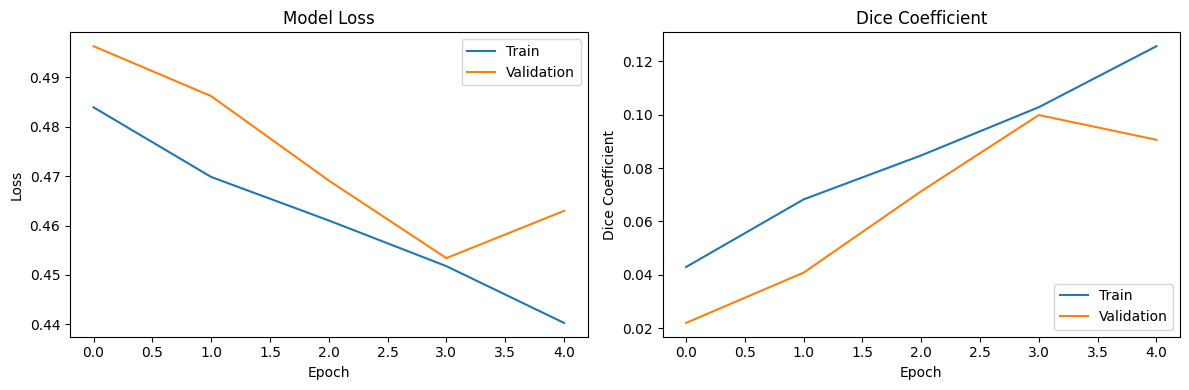

In [23]:
# Evaluation
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    # Plot training & validation dice coefficient
    plt.subplot(1, 2, 2)
    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    plt.title('Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.9766 - dice_coefficient: 0.1055 - loss: 0.4511

Test Metrics:
Test Loss: 0.4521
Test Dice Coefficient: 0.1041
Test Accuracy: 0.9782

Showing 5 best matching predictions:


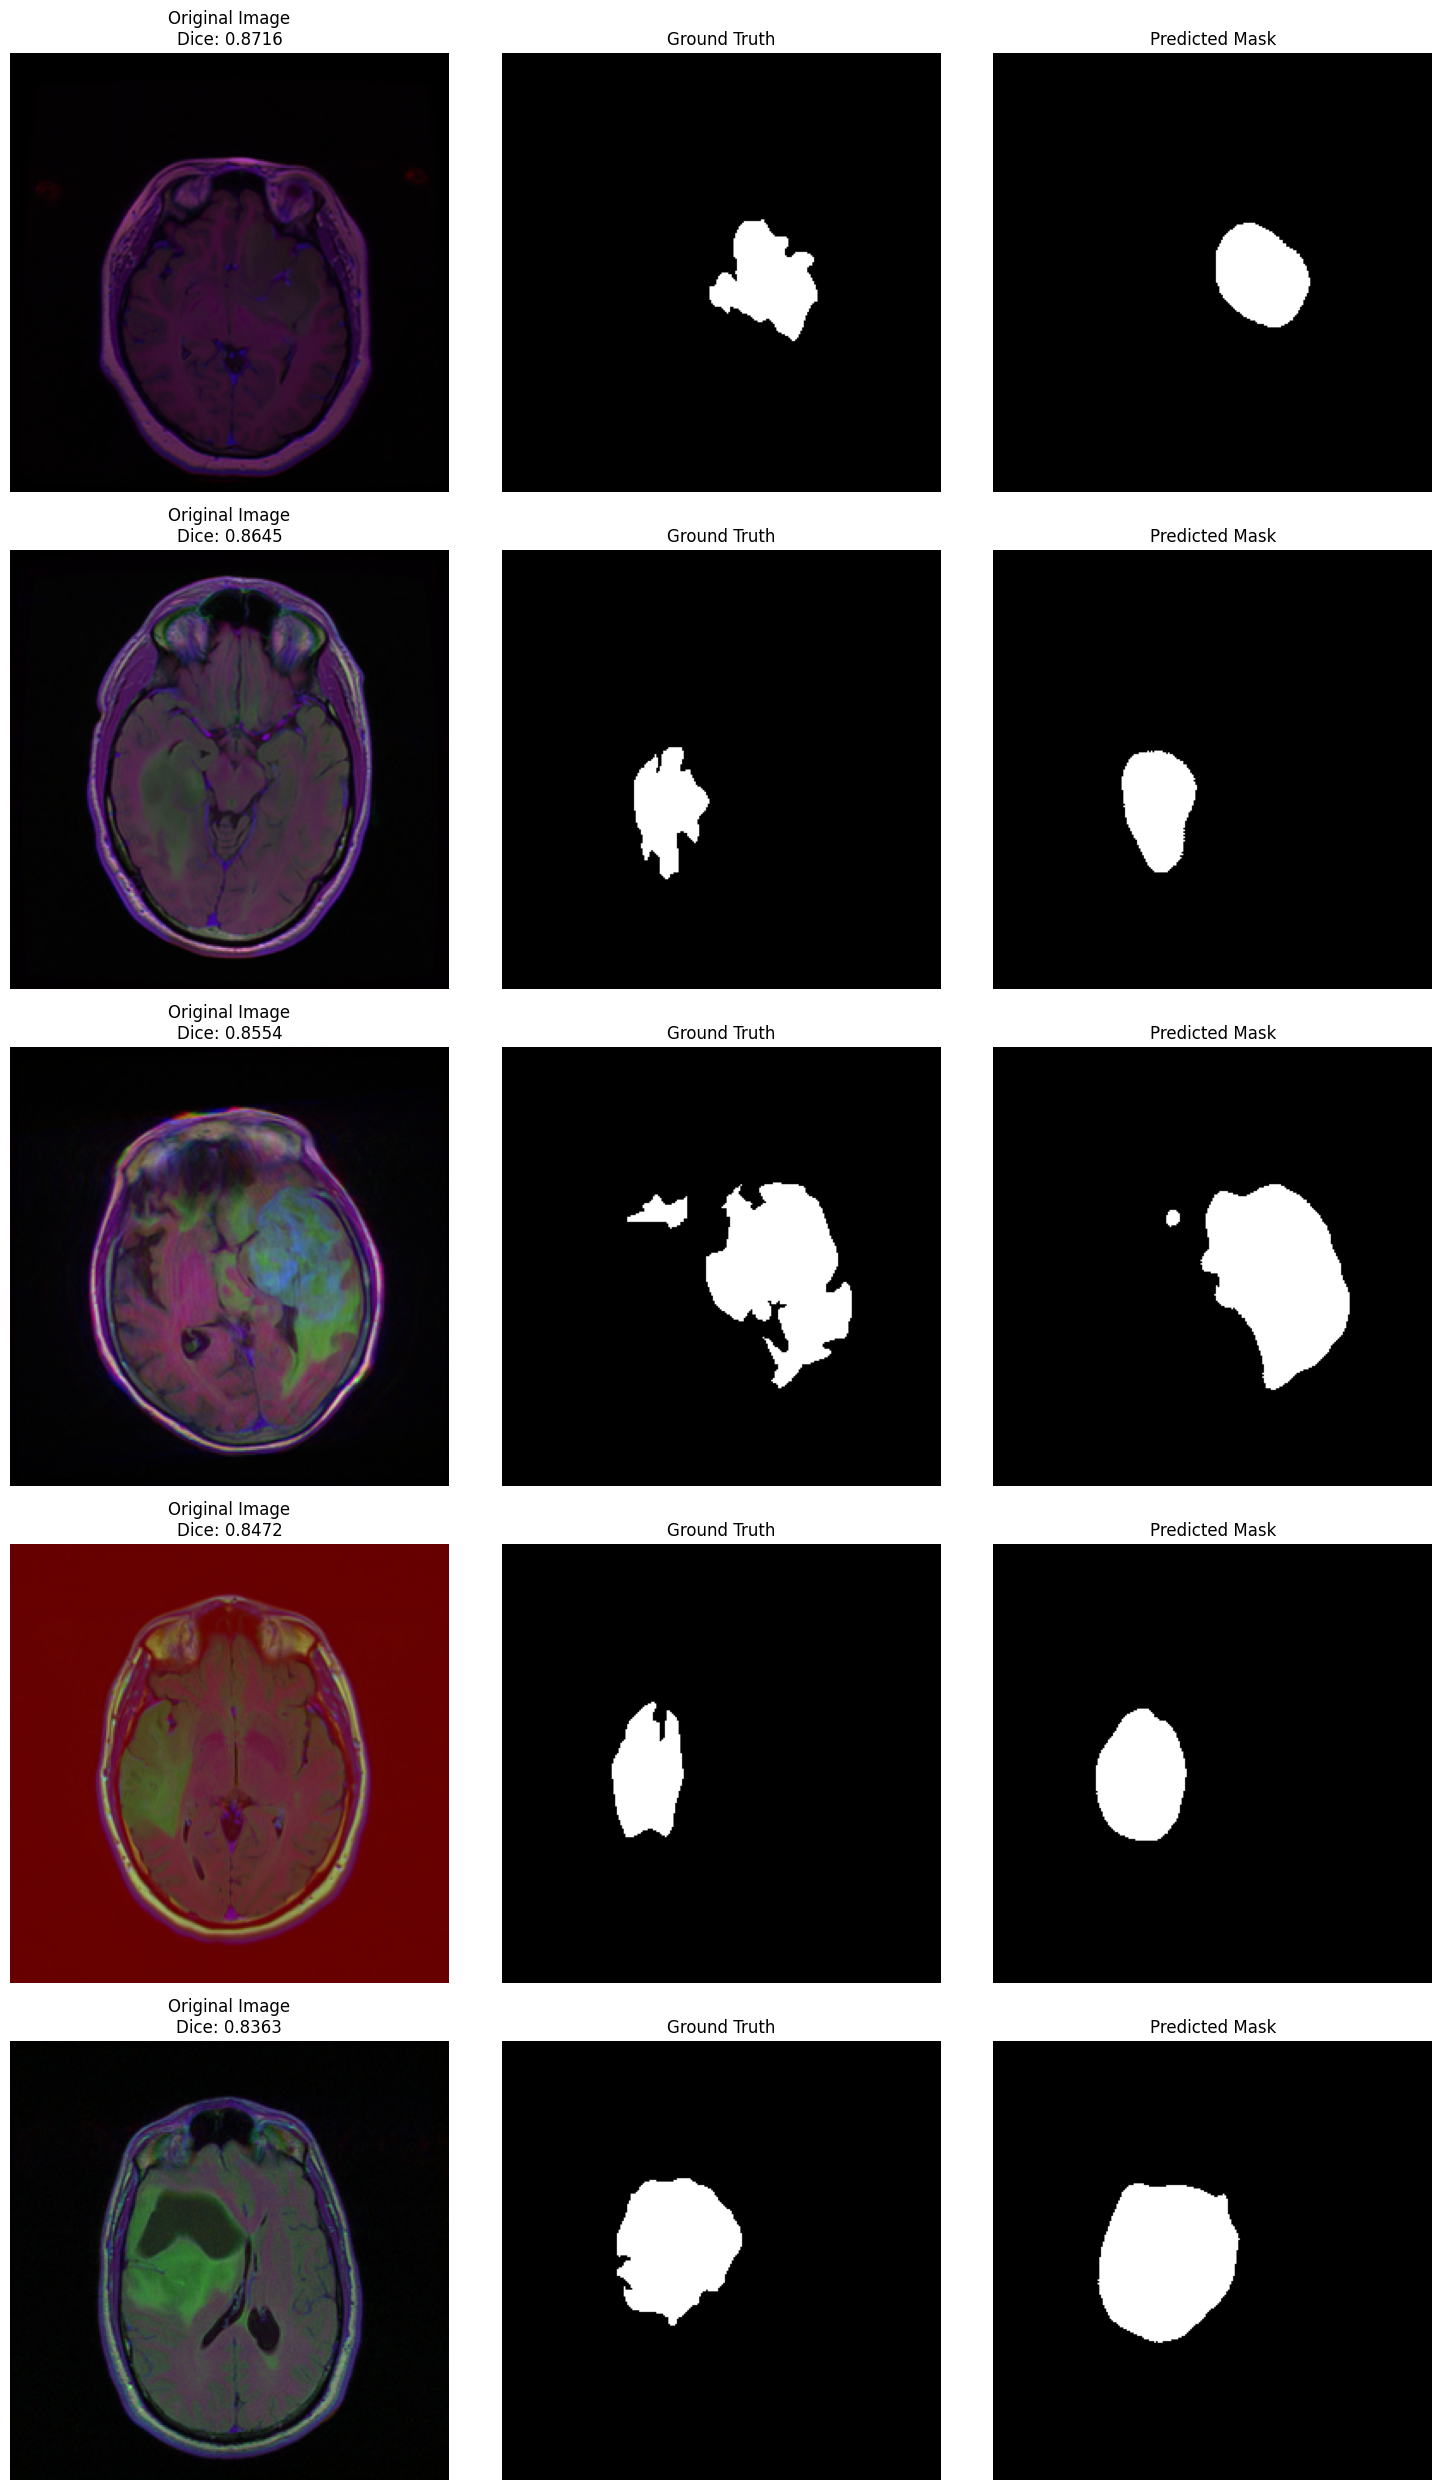

In [29]:
# Test evaluation and visualization of best matches
model.load_weights('best_model.keras')

def calculate_sample_dice(y_true, y_pred):
    """Calculate Dice coefficient for a single sample"""
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2. * intersection) / (union + 1e-6)  # Adding small epsilon to avoid division by zero

def plot_matches(model, dataset, num_samples=5):
    # Get all predictions and ground truths
    all_images = []
    all_masks = []
    all_preds = []
    dice_scores = []
    
    for images, masks in dataset:
        preds = model.predict(images, verbose=0)
        preds = (preds > 0.5).astype(np.float32)
        
        for i in range(len(images)):
            dice = calculate_sample_dice(masks[i].numpy(), preds[i])
            dice_scores.append(dice)
            all_images.append(images[i].numpy())
            all_masks.append(masks[i].numpy())
            all_preds.append(preds[i])
    
   
    top_indices = np.argsort(dice_scores)[-num_samples:][::-1]  # Sort descending
    
    plt.figure(figsize=(15, 5 * num_samples))
    for i, idx in enumerate(top_indices):
        # Original Image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(all_images[idx])
        plt.title(f"Original Image\nDice: {dice_scores[idx]:.4f}")
        plt.axis('off')
        
        # Ground Truth Mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(all_masks[idx], cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')
        
        # Predicted Mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(all_preds[idx], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# First evaluate on test set
test_results = model.evaluate(test_dataset, verbose=1)
print(f"\nTest Metrics:")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Dice Coefficient: {test_results[1]:.4f}")
print(f"Test Accuracy: {test_results[2]:.4f}")

# Then show the best matches
print("\nShowing random predictions:")
plot_matches(model, test_dataset, num_samples=5)